In [3]:
from tadv.utils import load_dotenv

load_dotenv()

from tadv.utils import get_task_instance
from tadv.utils import get_project_root

In [4]:
def task_group_mapping(task_type):
    return {
        'bi': 'sql',
        'dev': 'sql',
        'feature_engineering': 'sql',
        'classification': 'ml',
        'regression': 'ml',
        'info': 'web'
    }[task_type]

In [5]:
def print_instance(data_name):
    original_data_path = get_project_root() / "data" / f"{data_name}"
    task_instance_list = []
    for task_type in ['bi', 'dev', 'feature_engineering', 'classification', 'regression', 'info']:
        scripts_path_dir = original_data_path / "scripts" / task_group_mapping(task_type)
        for script_path in sorted(scripts_path_dir.iterdir(), key=lambda x: x.name):
            if task_type not in script_path.name:
                continue
            task_instance = get_task_instance(script_path)
            task_instance_list.append(task_instance)
    return task_instance_list


In [6]:



def plot_column_distribution(data_name):
    all_results = print_instance(data_name)
    required_columns = [all_results[i].annotations['required_columns'] for i in range(len(all_results))]
    if data_name == "playground-series-s4e10":
        all_columns_list = ['loan_int_rate', 'loan_status', 'person_income', 'person_home_ownership',
                            'cb_person_default_on_file', 'person_age', 'loan_amnt', 'loan_income_ratio', 'id',
                            'loan_intent', 'cb_person_cred_hist_length', 'loan_percent_income', 'loan_grade',
                            'person_emp_length']
    elif data_name == "healthcare_dataset":
        all_columns_list = ["id", "Name", "Age", "Gender", "Blood Type", "Medical Condition", "Date of Admission",
                            "Doctor",
                            "Hospital", "Insurance Provider", "Billing Amount", "Room Number", "Admission Type",
                            "Discharge Date", "Medication", "Test Results"]
    # create a num_instance x num_columns matrix
    required_columns_mask = np.zeros((len(required_columns), len(all_columns_list)))
    for i, required_column in enumerate(required_columns):
        for column in required_column:
            required_columns_mask[i, all_columns_list.index(column)] = 1
    # plot the distribution of required columns
    plt.figure(figsize=(10, 10))
    plt.imshow(required_columns_mask, aspect='auto')
    plt.xlabel('Column Index')
    plt.ylabel('Task Index')
    plt.xticks(np.arange(len(all_columns_list)), all_columns_list, rotation=45)
    plt.yticks(np.arange(len(required_columns)), [result.script_name for result in all_results])
    plt.title('Column Distribution')
    plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_column_distribution(data_name):
    all_results = print_instance(data_name)
    required_columns = [all_results[i].annotations['required_columns'] for i in range(len(all_results))]

    if data_name == "playground-series-s4e10":
        all_columns_list = [
            'loan_int_rate', 'loan_status', 'person_income', 'person_home_ownership',
            'cb_person_default_on_file', 'person_age', 'loan_amnt', 'id',
            'loan_intent', 'cb_person_cred_hist_length', 'loan_percent_income', 'loan_grade',
            'person_emp_length'
        ]
    elif data_name == "healthcare_dataset":
        all_columns_list = [
            "id", "Name", "Age", "Gender", "Blood Type", "Medical Condition", "Date of Admission",
            "Doctor", "Hospital", "Insurance Provider", "Billing Amount", "Room Number",
            "Admission Type", "Discharge Date", "Medication", "Test Results"
        ]

    # Create a num_instance x num_columns matrix
    required_columns_mask = np.zeros((len(required_columns), len(all_columns_list)))

    for i, required_column in enumerate(required_columns):
        for column in required_column:
            if column in all_columns_list:
                required_columns_mask[i, all_columns_list.index(column)] = 1

    # Set up the figure
    plt.figure(figsize=(12, max(6, len(required_columns) * 0.2)))

    # Use seaborn heatmap for better visualization
    sns.heatmap(required_columns_mask, cmap="Blues", cbar=False, linewidths=0.2,
                xticklabels=all_columns_list, yticklabels=[result.script_name for result in all_results])

    # Improve aesthetics
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Tasks', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('Column Requirement Distribution Across Tasks', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()
    return required_columns_mask

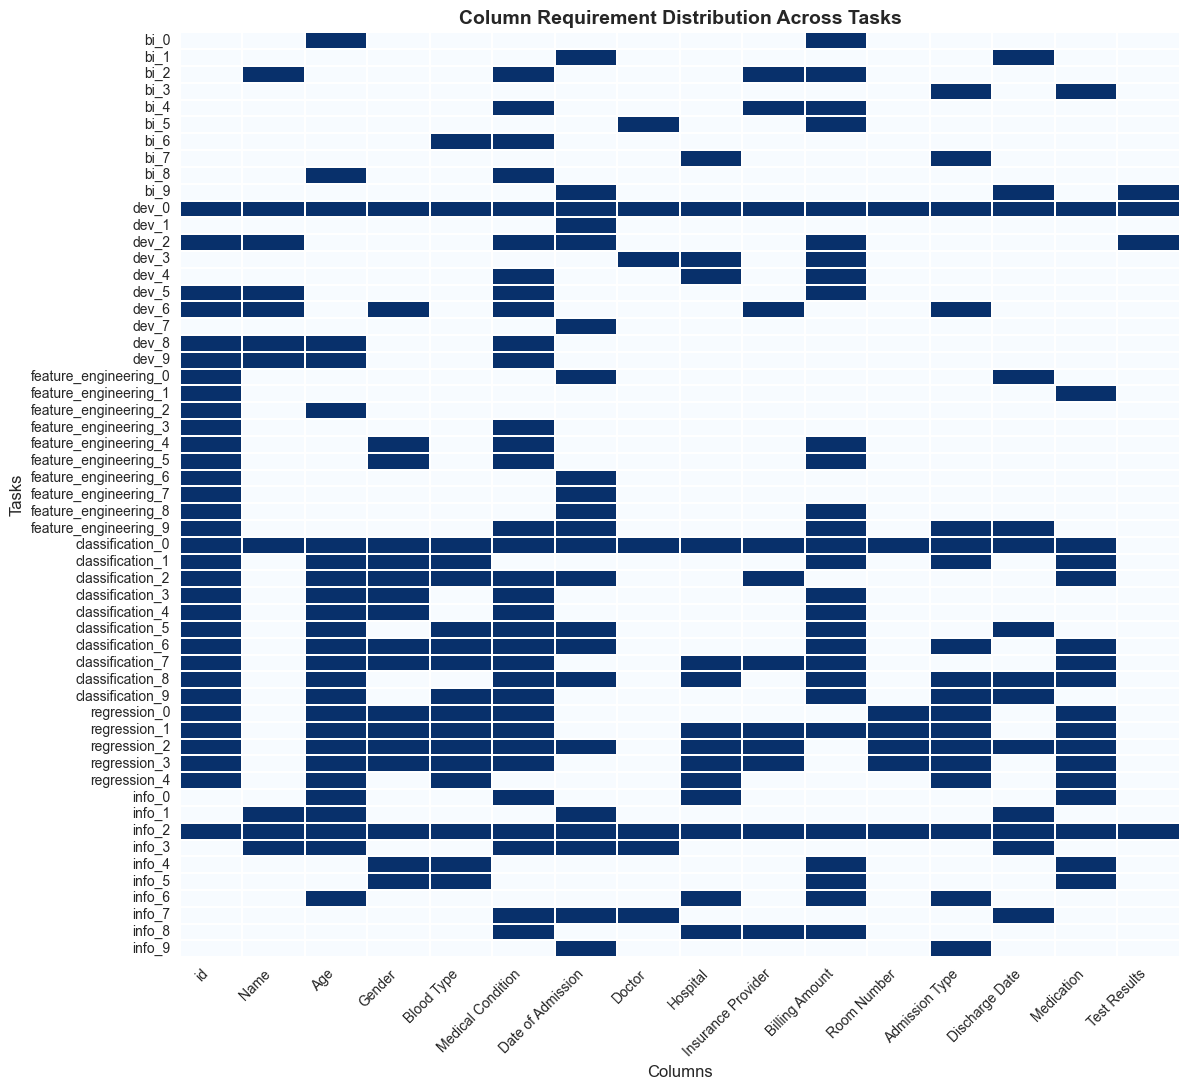

In [14]:
data_name = "healthcare_dataset"
required_columns_mask = plot_column_distribution(data_name)

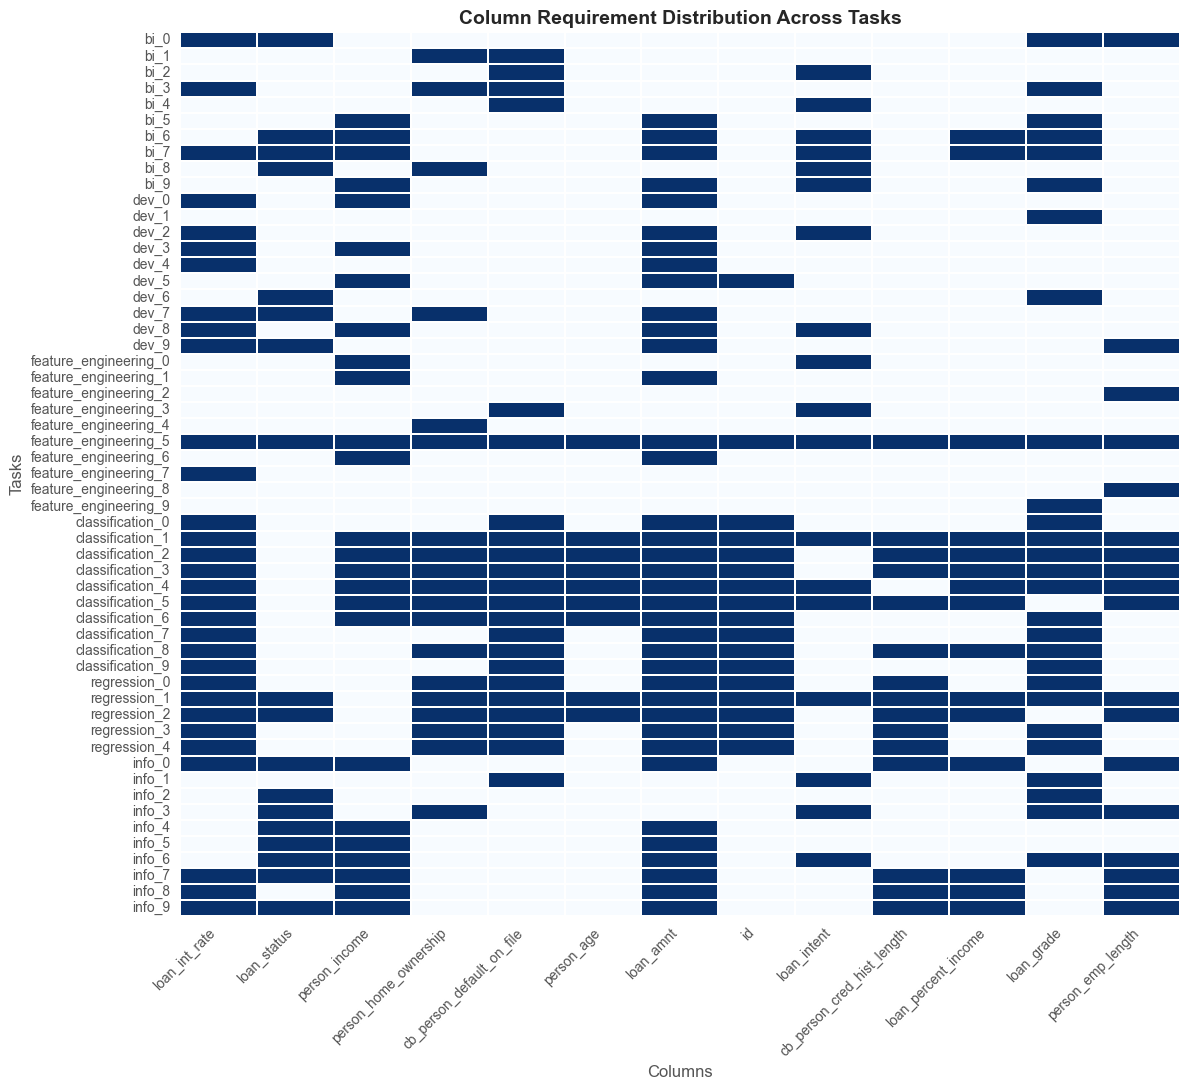

In [11]:
data_name = "playground-series-s4e10"
required_columns_mask = plot_column_distribution(data_name)

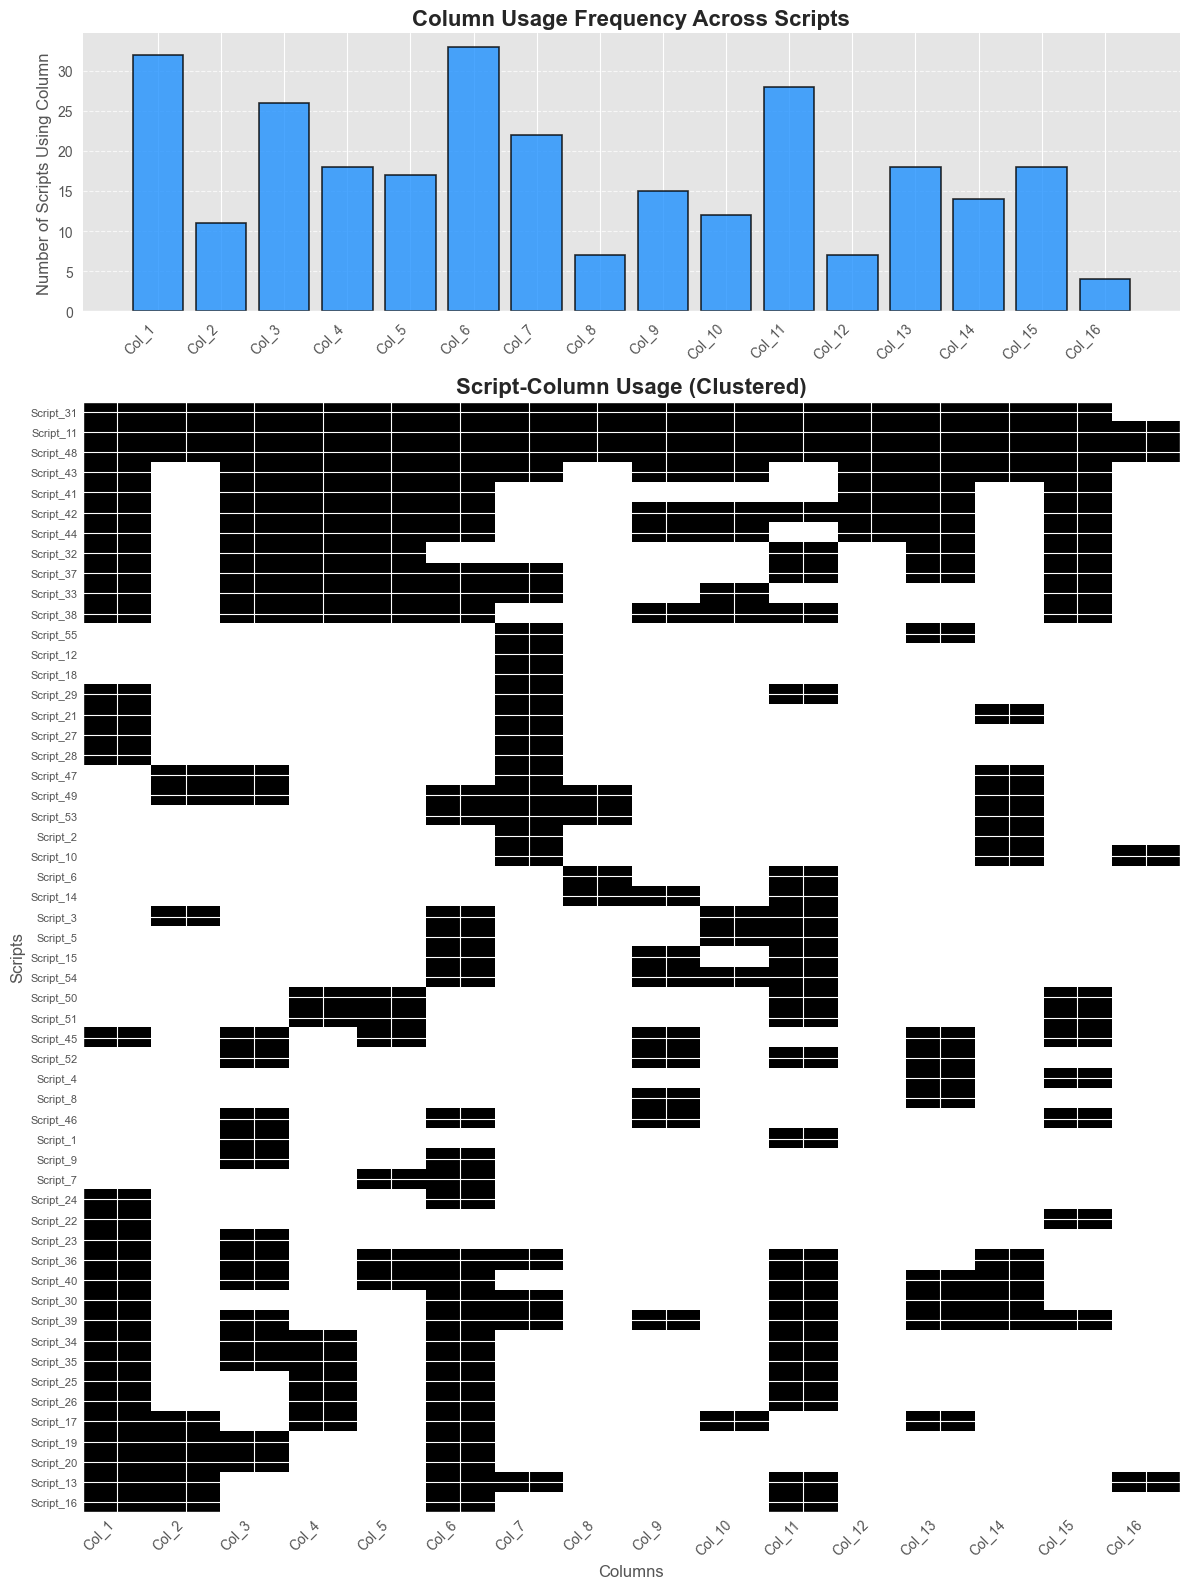

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

np.random.seed(42)
num_scripts = 55
num_columns = 16
data = required_columns_mask

# Convert to DataFrame
columns = [f"Col_{i+1}" for i in range(num_columns)]
scripts = [f"Script_{i+1}" for i in range(num_scripts)]
df = pd.DataFrame(data, index=scripts, columns=columns)

# Cluster scripts based on column usage similarity
linkage_matrix = linkage(df, method='ward')
script_order = leaves_list(linkage_matrix)  # Reorder rows based on clustering
df_clustered = df.iloc[script_order]

# Compute column usage summary
column_usage_counts = df_clustered.sum(axis=0)

# Set figure size and style
plt.style.use("ggplot")
fig, axes = plt.subplots(2, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [1, 4]})

# Stacked Bar Chart for Column Usage Summary
axes[0].bar(columns, column_usage_counts, color="dodgerblue", alpha=0.8, edgecolor="black", linewidth=1.2)
axes[0].set_ylabel("Number of Scripts Using Column", fontsize=12)
axes[0].set_title("Column Usage Frequency Across Scripts", fontsize=16, fontweight="bold")
axes[0].set_xticks(range(num_columns))
axes[0].set_xticklabels(columns, rotation=45, ha="right", fontsize=10)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Dot Matrix Plot
cmap = plt.cm.Greys
axes[1].imshow(df_clustered, aspect="auto", cmap=cmap, interpolation="none")
axes[1].set_yticks(range(num_scripts))
axes[1].set_yticklabels(df_clustered.index, fontsize=8)
axes[1].set_xticks(range(num_columns))
axes[1].set_xticklabels(columns, rotation=45, ha="right", fontsize=10)
axes[1].set_title("Script-Column Usage (Clustered)", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Columns", fontsize=12)
axes[1].set_ylabel("Scripts", fontsize=12)
axes[1].tick_params(axis="y", length=0)
axes[1].tick_params(axis="x", length=0)

# Adjust layout
plt.tight_layout()
plt.show()